In [60]:
import numpy as np
import pandas as pd

In [61]:
data = pd.read_csv('Fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [63]:
print(data.isnull().sum())
print(data.duplicated().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
0


In [64]:
print(data['isFraud'].value_counts())

isFraud
0    6354407
1       8213
Name: count, dtype: int64


In [65]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

In [66]:
# Assuming 'data' is already defined as a Pandas DataFrame
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])
data = data.drop(['nameOrig', 'nameDest'], axis=1)

X = data.drop(['isFraud'], axis=1)
y = data['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Resampling
X_train_res, y_train_res = resample(X_train[y_train == 1],
                                     y_train[y_train == 1],
                                     replace=True,
                                     n_samples=X_train[y_train == 0].shape[0],
                                     random_state=42)

# Combine the original and resampled data
X_train = pd.concat([X_train[y_train == 0], pd.DataFrame(X_train_res)], ignore_index=True)
y_train = np.hstack((y_train[y_train == 0], y_train_res))

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1906351
           1       0.08      0.98      0.15      2435

    accuracy                           0.99   1908786
   macro avg       0.54      0.98      0.57   1908786
weighted avg       1.00      0.99      0.99   1908786

ROC-AUC Score: 0.9847612460886268


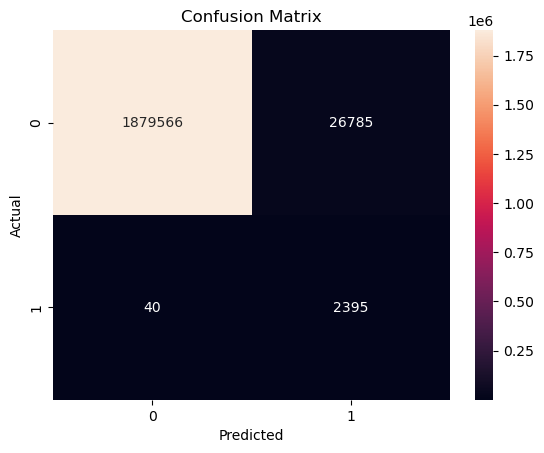

In [67]:
# Model
model = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [70]:
from imblearn.over_sampling import SMOTE

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42, k_neighbors=3)  # Adjust k_neighbors if necessary
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Limit the size of the resampled dataset if necessary
max_samples = 10000  # Adjust this number based on your needs
if X_train_smote.shape[0] > max_samples:
    X_train_smote, y_train_smote = X_train_smote[:max_samples], y_train_smote[:max_samples]

# Scaling
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)

# Model training with reduced parameters
model = RandomForestClassifier(n_estimators=20, max_depth=5, n_jobs=-1, random_state=42)
model.fit(X_train_smote, y_train_smote)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       1.00      0.18      0.30      2464

    accuracy                           1.00   1908786
   macro avg       1.00      0.59      0.65   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC-AUC Score: 0.589488374078461
